In [1]:
import warnings
import os

# Our numerical workhorse
import numpy as np
import scipy

# Image processing tools
import skimage
import skimage.io
import skimage.filters
import skimage.morphology
import skimage.feature
import skimage.segmentation
import skimage.measure

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Suppress future warnings
warnings.filterwarnings('ignore')

# Part A

In [ ]:
"/Users/"

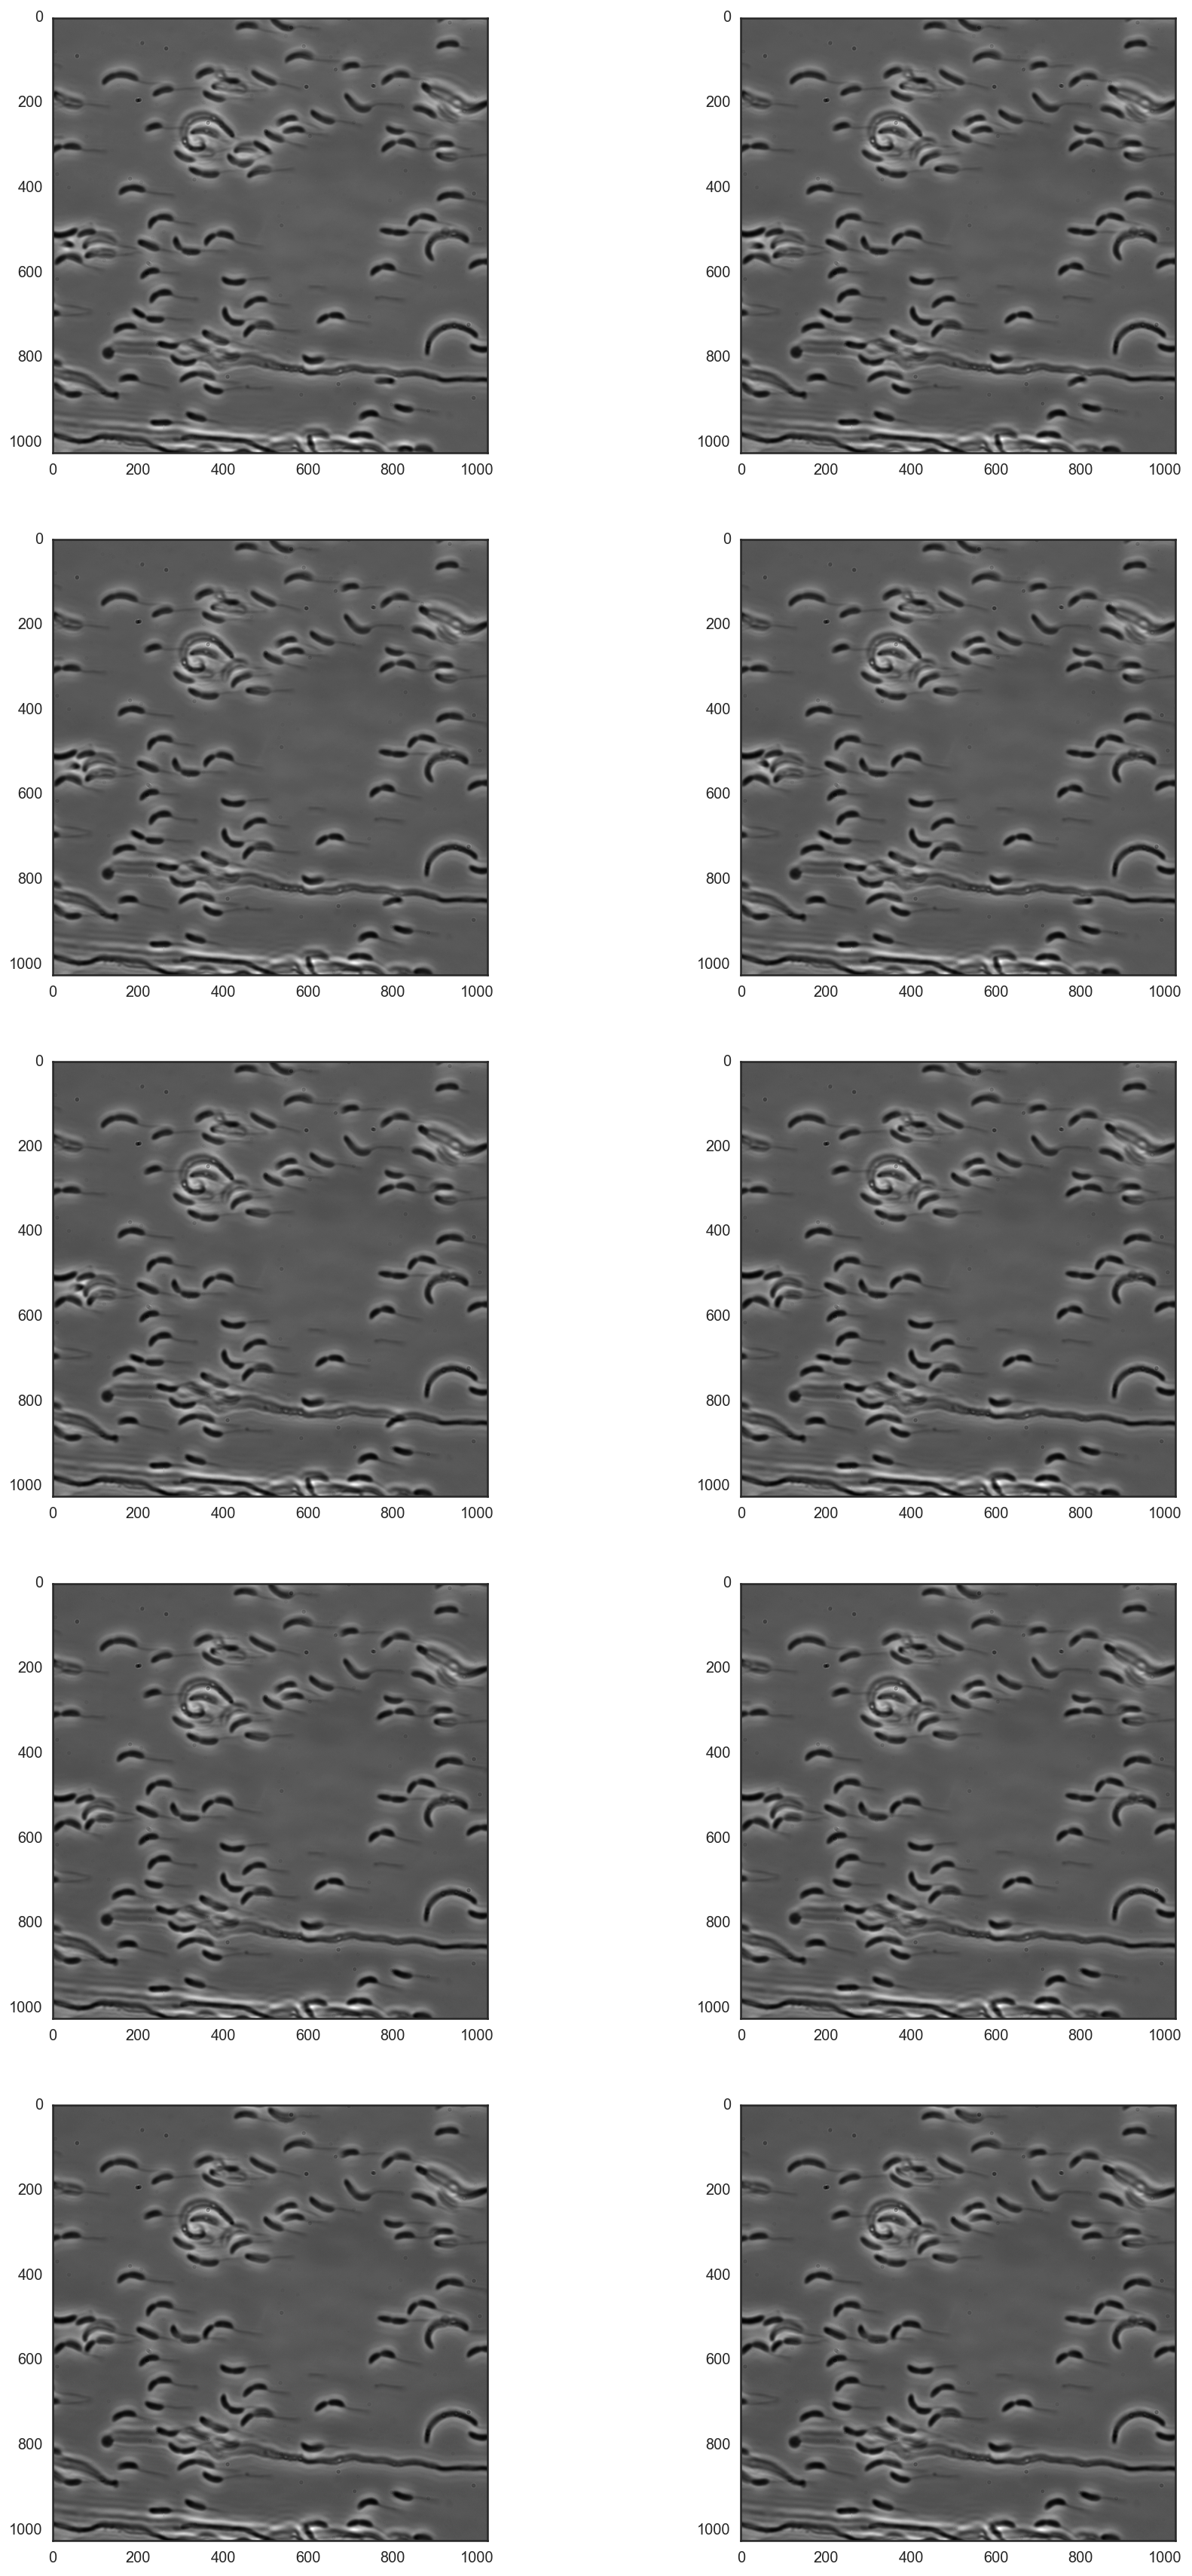

In [2]:
image_dir = '/Users/Shashank/Desktop/Caltech/GitHub/Personal/BE103-Data Analysis/hw8_iyer-biswas_et_al\
/sequential_full_field/phase0300'

im_list = []
im_float_list = []
f = plt.figure(figsize=(15,30))

for i in range(10):
    im_list.append(image_dir + str(i) + '.tif')

    im = skimage.io.imread(im_list[i])
    im_float_list.append((im.astype(float) - im.min()) / (im.max() - im.min()))
    
for i in range(10):
    with sns.axes_style('white'):
        plt.subplot(5,2,i+1)
        plt.imshow(im_float_list[i], cmap=plt.cm.gray)

In [ ]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_float_list[0], 2.0)

def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_edge, cmap=plt.cm.gray)

In [ ]:
# Structuring element is radius 2 disk
selem = skimage.morphology.disk(2)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
im_bw = scipy.ndimage.morphology.binary_fill_holes(im_bw)

# Structuring element is radius 3 disk
selem = skimage.morphology.disk(3)

# Erode binary image again
im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=500)

# Show result
with sns.axes_style('white'):
    plt.imshow(im_bw, cmap=plt.cm.gray)

# Part B

In [2]:
image_dir = '/Users/elenaperry/Dropbox/Caltech/bebi103/hw8_iyer-biswas_et_al/'
im_bac_1_file = os.path.join(image_dir, 'bacterium_1.tif')
im_bac_2_file = os.path.join(image_dir, 'bacterium_2.tif')

im_bac_1 = skimage.io.imread(im_bac_1_file)
im_bac_2 = skimage.io.imread(im_bac_2_file)

im_bac_1_float = np.empty(im_bac_1.shape)
for i in range(len(im_bac_1)):
    im_bac_1_float[i] = (im_bac_1[i].astype(float) - im_bac_1[i].min()) / (im_bac_1[i].max() - im_bac_1[i].min())

im_bac_2_float = np.empty(im_bac_2.shape)
for i in range(len(im_bac_2)):
    im_bac_2_float[i] = (im_bac_2[i].astype(float) - im_bac_2[i].min()) / (im_bac_2[i].max() - im_bac_2[i].min())

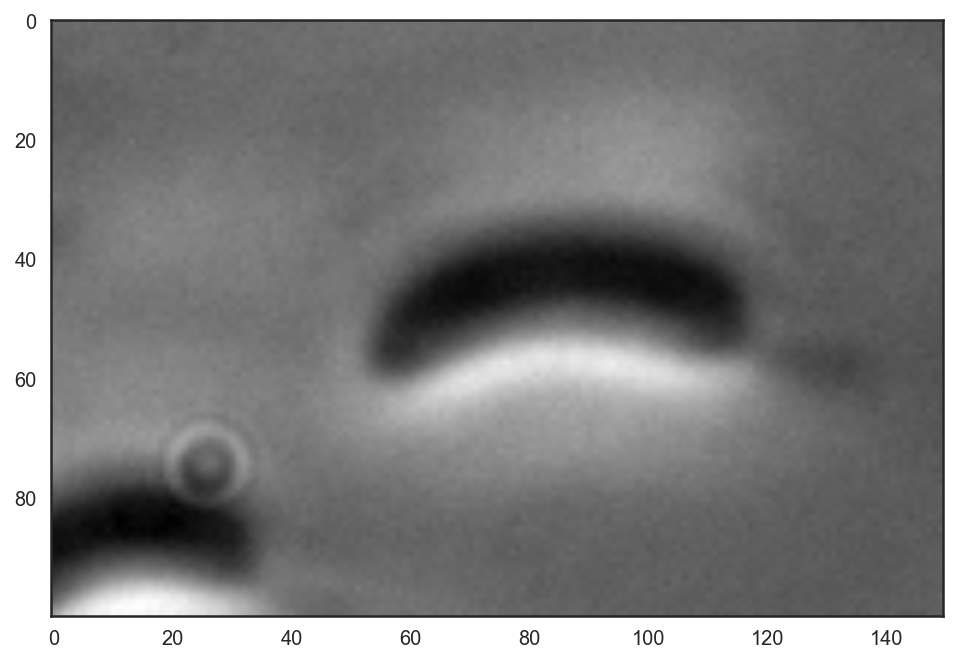

In [50]:
with sns.axes_style('white'):
    #fig, ax = plt.subplots(1, 2)
    #ax[0].imshow(im_bac_1_float[0], cmap=plt.cm.gray)
    #ax[1].imshow(im_bac_2_float[0], cmap=plt.cm.gray)
    plt.imshow(im_bac_1_float[554], cmap=plt.cm.gray)

In [ ]:
_ = plt.hist(im_bac_1_float[0], bins=20, histtype='step')

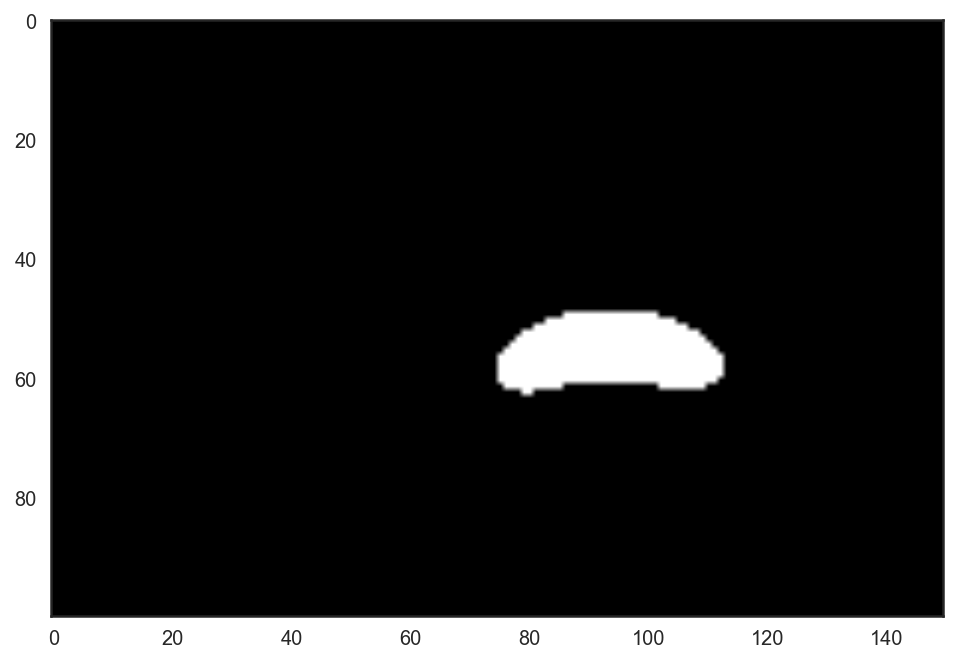

In [190]:
threshold = 0.3
im_bac_1_thresh = im_bac_1_float < threshold
for i in range(len(im_bac_1_thresh)):
    skimage.segmentation.clear_border(im_bac_1_thresh[i])

im_bac_1_thresh = im_bac_1_thresh.astype(int)
with sns.axes_style('white'):
    plt.imshow(im_bac_1_thresh[1], cmap=plt.cm.gray)

In [169]:
max_area = np.array([0.01] * len(im_bac_1_thresh))

for i in range(len(im_bac_1_thresh)):
    selem = skimage.morphology.square(2)
    im_bw_eroded = skimage.morphology.erosion(im_bac_1_thresh[i], selem)
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(
                                im_bw_eroded, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        #print("""
        #bacterium {0:d}: area = {1:.1f} µm^2
        #""".format(prop.label, prop.area * physical_size**2))
        if prop.area * physical_size**2 > max_area[i]:
            max_area[i] = prop.area * physical_size**2

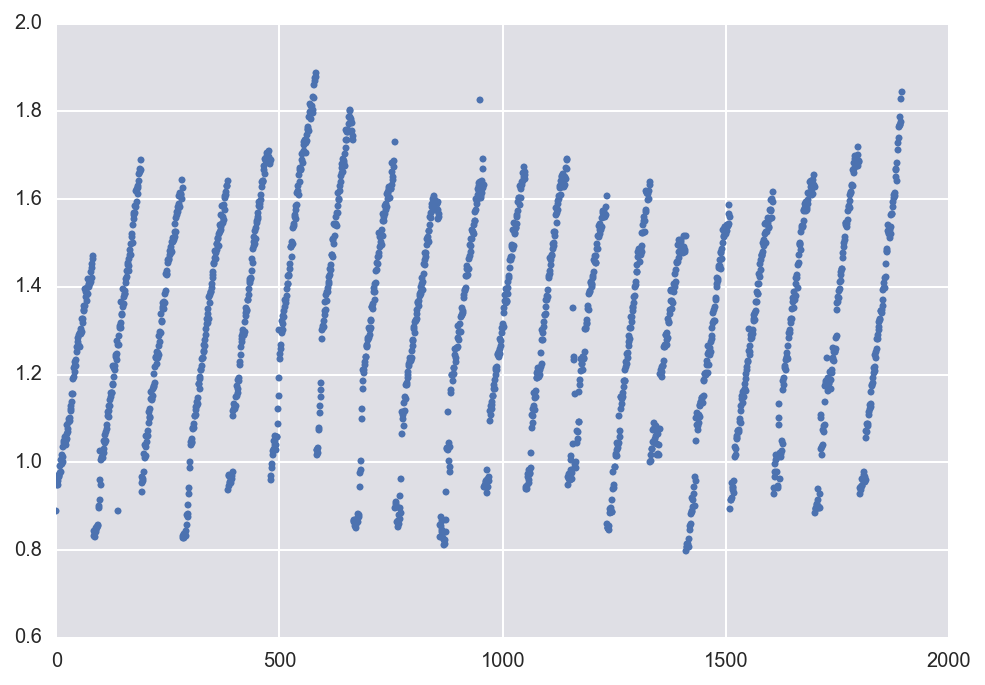

In [188]:
areas = max_area[(max_area > 0.7) & (max_area < 2.0)]
area_diff = np.diff(areas)
plt.plot(np.arange(len(areas)), areas, '.')

In [189]:
inter_div_inds = np.where(area_diff < -0.5)[0]
inter_div_time = np.diff(inter_div_inds)

# problem: because some frames were dropped, some of the inter_div_times will be a couple of minutes off (this can be fixed)

In [76]:
def zero_crossing_filter(im, thresh):
    """
    Returns image with 1 if there is a zero crossing and 0 otherwise.
    
    thresh is the the minimal value of the gradient, as computed by Sobel
    filter, at crossing to count as a crossing.
    """
    # Square structuring element
    selem = skimage.morphology.square(3)
    
    # Do max filter and min filter
    im_max = scipy.ndimage.filters.maximum_filter(im, footprint=selem)
    im_min = scipy.ndimage.filters.minimum_filter(im, footprint=selem)
    
    # Compute gradients using Sobel filter
    im_grad = skimage.filters.sobel(im)
    
    # Return edges
    return (((im >= 0) & (im_min < 0)) | ((im <= 0) & (im_max > 0))) \
                & (im_grad >= thresh)


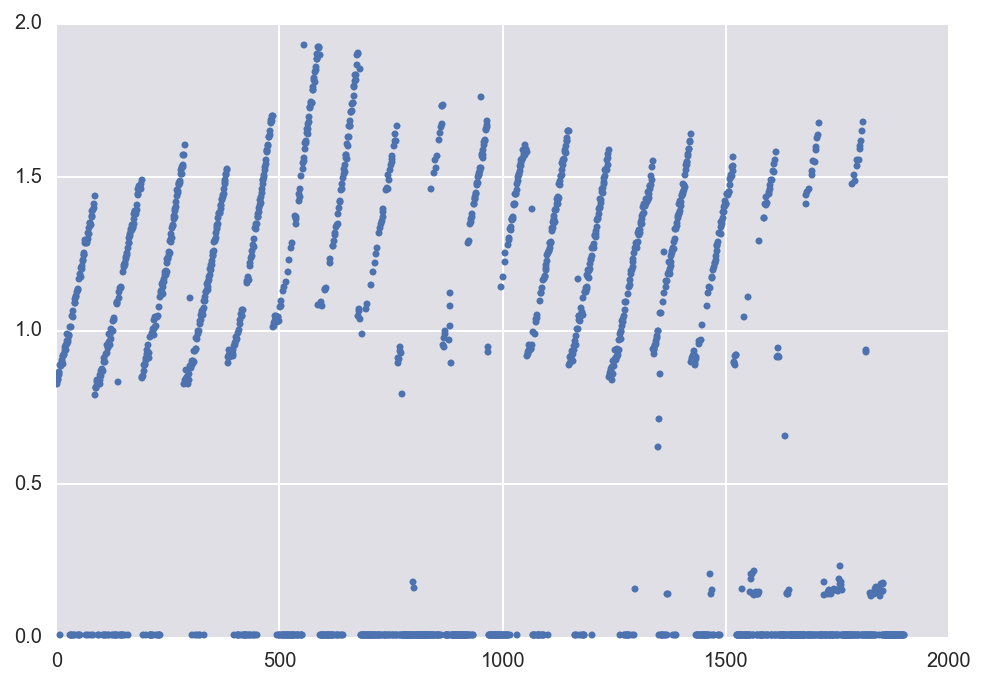

In [191]:
max_area = np.array([0.01] * len(im_bac_1_float))

for i in range(len(im_bac_1_float)):
    # Compute LoG
    im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_1_float[i], 2.0)

    # Find zero-crossings
    im_edge = zero_crossing_filter(im_LoG, 0.001)

    # Structuring element is radius 2 disk
    selem = skimage.morphology.disk(4)

    # Close binary image
    im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

    # Fill holes
    im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

    # Structuring element is radius 3 disk
    #selem = skimage.morphology.disk(3)

    # Erode binary image again
    im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

    # Remove small objectes that are not bacteria
    im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=50)
    
    # Label binary image
    im_labeled, n_labels = skimage.measure.label(im_bw, background=-1, return_num=True)

    # Get area of each bacterium and store the largest area in case of more than one bacterium
    physical_size = 0.052
    im_props = skimage.measure.regionprops(im_labeled)
    for prop in im_props:
        #print("""
        #bacterium {0:d}: area = {1:.1f} µm^2
        #""".format(prop.label, prop.area * physical_size**2))
        if prop.area * physical_size**2 > max_area[i]:
            max_area[i] = prop.area * physical_size**2

plt.plot(np.arange(len(im_bac_1_float)), max_area, '.')

In [194]:
np.where((max_area < 0.5) & (max_area > 0.05))

(array([ 800,  801, 1297, 1368, 1371, 1464, 1466, 1469, 1537, 1554, 1556,
        1557, 1559, 1561, 1563, 1564, 1565, 1566, 1567, 1568, 1572, 1573,
        1575, 1636, 1638, 1639, 1641, 1719, 1720, 1728, 1729, 1732, 1735,
        1743, 1744, 1747, 1748, 1752, 1754, 1755, 1756, 1757, 1758, 1760,
        1822, 1824, 1828, 1832, 1833, 1835, 1836, 1838, 1839, 1840, 1841,
        1843, 1844, 1845, 1846, 1847, 1848, 1851, 1852, 1853]),)

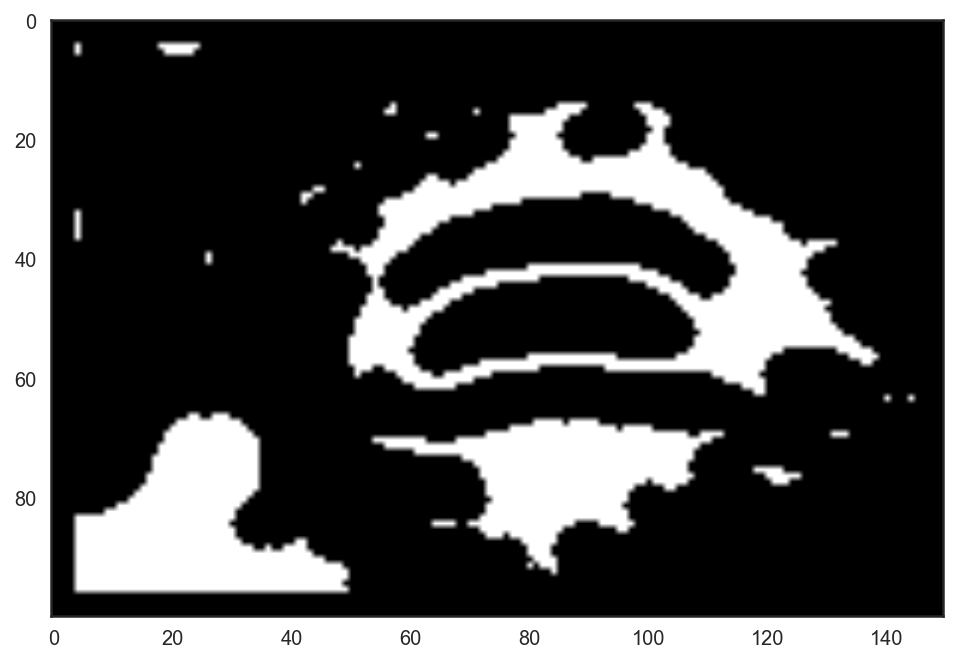

In [197]:
# Compute LoG
im_LoG = scipy.ndimage.filters.gaussian_laplace(im_bac_1_float[800], 2.0)

# Find zero-crossings
im_edge = zero_crossing_filter(im_LoG, 0.001)

# Structuring element is radius 2 disk
selem = skimage.morphology.disk(4)

# Close binary image
im_bw_close = skimage.morphology.binary_closing(im_edge, selem)

# Remove small objectes that are not bacteria
#im_bw = skimage.morphology.remove_small_objects(im_bw_close, min_size=500)

# Fill holes
#im_bw = scipy.ndimage.morphology.binary_fill_holes(im_edge)

# Structuring element is radius 3 disk
#selem = skimage.morphology.disk(3)

# Erode binary image again
#im_bw_eroded = skimage.morphology.erosion(im_bw, selem)

# Remove small objectes that are not bacteria
#im_bw = skimage.morphology.remove_small_objects(im_bw_eroded, min_size=50)

with sns.axes_style('white'):
    plt.imshow(im_bw_close, cmap=plt.cm.gray)

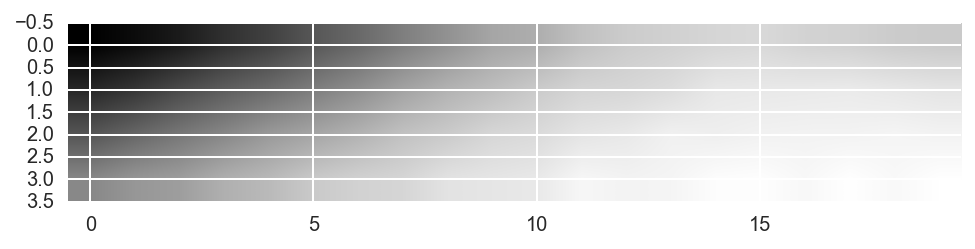

In [94]:
plt.imshow(im_bac_1_float[0][58:62,60:80], cmap=plt.cm.gray)

In [177]:
len(max_area)

1900

In [178]:
5/1900

0.002631578947368421